# **Building custom sources with [dlt REST API source](https://dlthub.com/docs/devel/dlt-ecosystem/verified-sources/rest_api/basic) and [RESTClient](https://dlthub.com/docs/devel/general-usage/http/rest-client)**

# New section

# **Recap**

In the **[dlt Fundamentals](https://github.com/dlt-hub/dlthub-education/tree/main/courses/dlt_fundamentals_dec_2024)** course, we learned two primary ways to build sources for REST APIs:

1. **Using low-level dlt decorators** (`@dlt.source` and `@dlt.resource`) with [`RESTClient`](https://dlthub.com/docs/devel/general-usage/http/rest-client).
2. **Using the built-in [`rest_api` source](https://dlthub.com/docs/devel/dlt-ecosystem/verified-sources/rest_api/basic)** with declarative configuration.

---



### **1. Building sources with low-level dlt decorators**

We constructed a custom source for the **GitHub API** using the `RESTClient` class, decorators like `@dlt.resource` and `@dlt.source`, and manual pagination handling.


#### **Example**

In [1]:
%%capture
!pip install dlt[duckdb]

In [4]:
import os
import dlt
from dlt.sources.helpers import requests
from dlt.sources.helpers.rest_client import RESTClient
from dlt.sources.helpers.rest_client.auth import BearerTokenAuth
from dlt.sources.helpers.rest_client.paginators import HeaderLinkPaginator
from google.colab import userdata


os.environ["ACCESS_TOKEN"] = userdata.get('SECRET_KEY')


@dlt.source
def github_source(access_token=dlt.secrets.value):
    client = RESTClient(
        base_url="https://api.github.com",
        auth=BearerTokenAuth(token=access_token),
        paginator=HeaderLinkPaginator(),
    )

    @dlt.resource
    def github_events():
        for page in client.paginate("orgs/dlt-hub/events"):
            yield page

    @dlt.resource
    def github_stargazers():
        for page in client.paginate("repos/dlt-hub/dlt/stargazers"):
            yield page

    return github_events, github_stargazers



pipeline = dlt.pipeline(
    pipeline_name="rest_client_github",
    destination="duckdb",
    dataset_name="rest_client_data",
    dev_mode=True,
)

load_info = pipeline.run(github_source())
print(load_info)

Pipeline rest_client_github load step completed in 6.27 seconds
1 load package(s) were loaded to destination duckdb and into dataset rest_client_data_20250509031150
The duckdb destination used duckdb:////content/rest_client_github.duckdb location to store data
Load package 1746803510.3199658 is LOADED and contains no failed jobs


In [ ]:
# print events and stargazers tables as dataframe
print(pipeline.dataset().github_events.df())
print(pipeline.dataset().github_stargazers.df())


---

### **2. Building sources with `rest_api` source**

The **`rest_api` source** provides a higher-level, declarative approach to building sources for REST APIs. It's particularly suited for REST APIs with predictable structures and behaviors.


#### **Example**

In [7]:
import dlt
from dlt.sources.rest_api import RESTAPIConfig, rest_api_source

config: RESTAPIConfig = {
    "client": {
        "base_url": "https://api.github.com",
        "auth": {
            "token": dlt.secrets["access_token"],  # Access token configured above
        },
        "paginator": "header_link"
    },
    "resources": [
        {
            "name": "issues",
            "endpoint": {
                "path": "repos/dlt-hub/dlt/issues",
                "params": {"state": "open"},
            },
        },
        {
            "name": "issue_comments",
            "endpoint": {
                "path": "repos/dlt-hub/dlt/issues/{issue_number}/comments",
                "params": {
                    "issue_number": {
                        "type": "resolve",
                        "resource": "issues",
                        "field": "number",
                    },
                },
            },
        },
        {
            "name": "contributors",
            "endpoint": {"path": "repos/dlt-hub/dlt/contributors"},
        },
    ],
}

github_source = rest_api_source(config)

pipeline = dlt.pipeline(
    pipeline_name="rest_api_github",
    destination="duckdb",
    dataset_name="rest_api_data",
    dev_mode=True,
)

load_info = pipeline.run(github_source)
print(load_info)

Pipeline rest_api_github load step completed in 1.54 seconds
1 load package(s) were loaded to destination duckdb and into dataset rest_api_data_20250509031726
The duckdb destination used duckdb:////content/rest_api_github.duckdb location to store data
Load package 1746803846.843478 is LOADED and contains no failed jobs


In [ ]:
print(pipeline.dataset().issues.df())
print(pipeline.dataset().issue_comments.df())
print(pipeline.dataset().contributors.df())

# **REST API Client by `dlt`**

`dlt`’s REST API Client is the low level abstraction that powers the REST API Source. You can use it in your imperative code for more automation and brevity, if you do not wish to use the higher level declarative interface.

If you don't like black boxes and prefer lower-level building blocks, then our `RESTClient` is perfect for you!

The `RESTClient` class offers an Pythonic interface for interacting with RESTful APIs, including features like:

- automatic pagination,
- various authentication mechanisms,
- customizable request/response handling.

### What you’ll learn

- How to authenticate with your API key
- How to fetch paginated results using `RESTClient`
- How to build a custom `@dlt.source`
- How to run the pipeline and inspect the data

For more information, read `dlt` [REST API Client](https://dlthub.com/devel/general-usage/http/rest-client) official documentation.

## **1. Creating a RESTClient instance**

In [11]:
from dlt.sources.helpers.rest_client import RESTClient
from dlt.sources.helpers.rest_client.auth import BearerTokenAuth
from dlt.sources.helpers.rest_client.paginators import JSONLinkPaginator
from google.colab import userdata


os.environ["ACCESS_TOKEN"] = userdata.get('SECRET_KEY')


client = RESTClient(
        base_url="https://api.github.com",
        headers={"User-Agent": "MyApp/1.0"},
        auth=BearerTokenAuth(dlt.secrets["access_token"]),
        paginator=HeaderLinkPaginator(),
        data_selector="data",
        # session=MyCustomSession()
    )

client.get("repos/dlt-hub/dlt/issues").json()

[{'url': 'https://api.github.com/repos/dlt-hub/dlt/issues/2619',
  'repository_url': 'https://api.github.com/repos/dlt-hub/dlt',
  'labels_url': 'https://api.github.com/repos/dlt-hub/dlt/issues/2619/labels{/name}',
  'comments_url': 'https://api.github.com/repos/dlt-hub/dlt/issues/2619/comments',
  'events_url': 'https://api.github.com/repos/dlt-hub/dlt/issues/2619/events',
  'html_url': 'https://github.com/dlt-hub/dlt/pull/2619',
  'id': 3052468483,
  'node_id': 'PR_kwDOGvRYu86VmlCs',
  'number': 2619,
  'title': 'Detect wether query just filters rows or is more complex with sqlglot',
  'user': {'login': 'anuunchin',
   'id': 88698977,
   'node_id': 'MDQ6VXNlcjg4Njk4OTc3',
   'avatar_url': 'https://avatars.githubusercontent.com/u/88698977?v=4',
   'gravatar_id': '',
   'url': 'https://api.github.com/users/anuunchin',
   'html_url': 'https://github.com/anuunchin',
   'followers_url': 'https://api.github.com/users/anuunchin/followers',
   'following_url': 'https://api.github.com/users/a

The `RESTClient` class is initialized with the following parameters:

- `base_url`: The root URL of the API. All requests will be made relative to this URL.
- `headers`: Default headers to include in every request. This can be used to set common headers like `User-Agent` or other custom headers.
- `auth`: The authentication configuration. See the [Authentication](https://dlthub.com/docs/general-usage/http/rest-client#authentication) section for more details.
- `paginator`: A paginator instance for handling paginated responses. See the [Paginators](https://dlthub.com/docs/general-usage/http/rest-client#paginators) section below.
- `data_selector`: A [JSONPath selector](https://github.com/h2non/jsonpath-ng?tab=readme-ov-file#jsonpath-syntax) for extracting data from the responses. This defines a way to extract the data from the response JSON. Only used when paginating.
- `session`: An optional session for making requests. This should be a [Requests session](https://requests.readthedocs.io/en/latest/api/#requests.Session) instance that can be used to set up custom request behavior for the client.


## **2. Add authentication**

The RESTClient supports various authentication strategies, such as bearer tokens, API keys, and HTTP basic auth, configured through the `auth` parameter of both the `RESTClient` and the `paginate()` method.

The **available authentication methods** are defined in the `dlt.sources.helpers.rest_client.auth` module:

- [BearerTokenAuth](https://dlthub.com/docs/devel/general-usage/http/rest-client#bearer-token-authentication)
- [APIKeyAuth](https://dlthub.com/docs/devel/general-usage/http/rest-client#api-key-authentication)
- [HttpBasicAuth](https://dlthub.com/docs/devel/general-usage/http/rest-client#http-basic-authentication)
- [OAuth2ClientCredentials](https://dlthub.com/docs/devel/general-usage/http/rest-client#oauth-20-authorization)

For specific use cases, you can [implement custom authentication](https://dlthub.com/docs/devel/general-usage/http/rest-client#implementing-custom-authentication) by subclassing the `AuthConfigBase` class from the [`dlt.sources.helpers.rest_client.auth`](https://github.com/dlt-hub/dlt/blob/devel/dlt/sources/helpers/rest_client/auth.py) module.
For specific flavors of OAuth 2.0, you can [implement custom OAuth 2.0](https://dlthub.com/docs/devel/general-usage/http/rest-client#oauth-20-authorization) by subclassing `OAuth2ClientCredentials`.




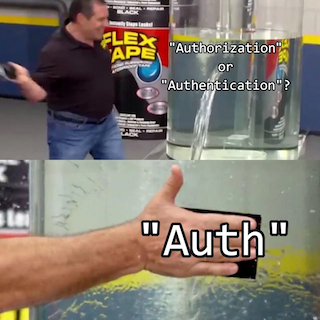


### 📰 **NewsAPI overview**

- **Base URL:** `https://newsapi.org/v2/`
- **Authentication:** API key passed in query string as `apiKey`
- **Documentation:** [NewsAPI Docs](https://newsapi.org/docs)

| Endpoint          | Description                              | Auth Required | Response     |
|-------------------|------------------------------------------|---------------|--------------|
| `/everything`     | Search for news articles by query string | ✅ Yes        | JSON object with `articles[]` |
| `/top-headlines`  | Latest headlines filtered by region/topic| ✅ Yes        | JSON object with `articles[]` |
| `/sources`        | List of available news sources           | ✅ Yes        | JSON object with `sources[]`  |


#### **Authentication Details:**

To use NewsAPI, you must register for a **free account** and obtain an API key. This key is required for all endpoints and must be included as a query parameter in your request:

```http
GET /v2/everything?q=python&page=1&apiKey=YOUR_API_KEY
```





**Prerequisites:**

To securely access the NewsAPI in your dlt project:

1. **Sign up** at [https://newsapi.org/register](https://newsapi.org/register)
2. Copy your **API key** from your dashboard
3. Save your **API key** in Colab Secrets (side-bar on the right) as NEWS_API_KEY


### **How we chose the right authenticator for NewsAPI**

NewsAPI uses a **simple API key-based scheme**. You sign up, get a key, and send it with every request.

There are two supported ways to send this key:

- In a **query string**, like `?apiKey=...`
- Or in the **Authorization header**, as a Bearer token

We are using the **query string method**, because:

- It's supported on **all plans**, including the free tier
- It's more transparent — you can inspect the request URL and see the key
- It's easier to test manually in a browser or terminal


**Using `APIKeyAuth` simplifies request setup**

Instead of manually appending the key to every URL, we use dlt’s built-in `APIKeyAuth`:

```python
APIKeyAuth(name="apiKey", api_key=api_key, location="query")
```

This means:

- `name="apiKey"` tells it what the key is called (NewsAPI expects `apiKey`)
- `location="query"` means the key will be added to the URL as a query parameter:
  
  ```
  https://newsapi.org/v2/everything?q=python&apiKey=your_key
  ```




In [12]:
%%capture
!pip install dlt[duckdb]

In [13]:
import os
from dlt.sources.helpers.rest_client import RESTClient
from dlt.sources.helpers.rest_client.auth import APIKeyAuth
from google.colab import userdata

api_key = userdata.get('NEWS_API_KEY')

client = RESTClient(
    base_url="https://newsapi.org/v2/",
    auth=APIKeyAuth(name="apiKey", api_key=api_key, location="query")
)

response = client.get("everything", params={"q": "python", "page": 1})
print(response.json())

{'status': 'ok', 'totalResults': 26766, 'articles': [{'source': {'id': None, 'name': 'Hackaday'}, 'author': 'Lewin Day', 'title': 'Hardware Built For Executing Python (Not Pythons)', 'description': 'Lots of microcontrollers will accept Python these days, with CircuitPython and MicroPython becoming ever more popular in recent years. However, there’s now a new player in town. Enter PyXL, a …read more', 'url': 'https://hackaday.com/2025/05/06/hardware-built-for-executing-python-not-pythons/', 'urlToImage': 'https://hackaday.com/wp-content/uploads/2025/04/Screenshot-2025-05-01-114025-e1746063734236.png', 'publishedAt': '2025-05-06T08:00:53Z', 'content': 'Lots of microcontrollers will accept Python these days, with CircuitPython and MicroPython becoming ever more popular in recent years. However, there’s now a new player in town. Enter PyXL, a project… [+1447 chars]'}, {'source': {'id': None, 'name': 'Edward-li.com'}, 'author': None, 'title': 'Advanced Python Features', 'description': 'Pyth

This authenticates every request by adding `?apiKey=your_key` to the URL.

## **3. Add pagination**

The `RESTClient` supports automatic pagination of API responses via the `paginate()` method, which can be customized using a built-in or custom paginator.

You specify the paginator using the `paginator` parameter of the `RESTClient` or directly in the `paginate()` method.

The **available pagination strategies** are defined in the `dlt.sources.helpers.rest_client.paginators` module and cover the most common pagination patterns used in REST APIs:

- [`PageNumberPaginator`](https://dlthub.com/docs/general-usage/http/rest-client#pagenumberpaginator) – uses `page=N`, optionally with `pageSize` or `limit`
- [`OffsetPaginator`](https://dlthub.com/docs/general-usage/http/rest-client#offsetpaginator) – uses `offset` and `limit`
- [`JSONLinkPaginator`](https://dlthub.com/docs/general-usage/http/rest-client#jsonresponsepaginator) – follows a `next` URL in the response body
- [`HeaderLinkPaginator`](https://dlthub.com/docs/general-usage/http/rest-client#headerlinkpaginator) – follows a `Link` header (used by GitHub and others)
- [`JSONResponseCursorPaginator`](https://dlthub.com/docs/general-usage/http/rest-client#jsonresponsecursorpaginator) – uses a cursor from the response body

Each paginator knows how to update the request to get the next page of results, and will continue until:

- no more pages are available,
- a configurable `maximum_page` or `maximum_offset` is reached,
- or the API response is empty (depending on paginator behavior).


> If a `paginator` is not specified, the `paginate()` method will attempt to **automatically detect** the pagination mechanism used by the API. If the API uses a standard pagination mechanism like having a `next` link in the response's headers or JSON body, the `paginate()` method will handle this automatically. Otherwise, you can specify a paginator object explicitly or implement a custom paginator.



### **PageData**

When using `client.paginate(...)` in dlt, you don’t just get a stream of data — each **page** returned is a rich object called `PageData`, and it gives you full access to the internals of the request, response, and pagination state.

This is especially useful for **debugging**, **tracing**, or building custom logic.


The `PageData` is a list-like object that contains the following attributes:

- `request`: The original request object.
- `response`: The response object.
- `paginator`: The paginator object used to paginate the response.
- `auth`: The authentication object used for the request.

Let’s walk through an example.

In [14]:
response = client.paginate("everything", params={"q": "python", "page": 1})
# prints the original request object
print(next(response).request)
response = client.paginate("everything", params={"q": "python", "page": 1})
# prints the raw HTTP response
print(next(response).response)
response = client.paginate("everything", params={"q": "python", "page": 1})
# prints the paginator that was used
print(next(response).paginator)
response = client.paginate("everything", params={"q": "python", "page": 1})
# prints the authentication class used
print(next(response).auth)


2025-05-09 15:24:07,377|[WARNING]|801|138201643204608|dlt|client.py|detect_paginator:312|Fallback paginator used: SinglePagePaginator at 7db12d593210. Please provide right paginator manually.


<Request [GET]>


2025-05-09 15:24:07,874|[WARNING]|801|138201643204608|dlt|client.py|detect_paginator:312|Fallback paginator used: SinglePagePaginator at 7db13dad1550. Please provide right paginator manually.
2025-05-09 15:24:07,978|[WARNING]|801|138201643204608|dlt|client.py|detect_paginator:312|Fallback paginator used: SinglePagePaginator at 7db12d6dd410. Please provide right paginator manually.


<Response [200]>
SinglePagePaginator at 7db12d6dd410


2025-05-09 15:24:08,082|[WARNING]|801|138201643204608|dlt|client.py|detect_paginator:312|Fallback paginator used: SinglePagePaginator at 7db134c13cd0. Please provide right paginator manually.


**Log Warning explained**

```
[WARNING] Fallback paginator used: SinglePagePaginator...
```

This warning means:

- dlt tried to guess the pagination method but failed
- It will make only **one request**
- You won’t get multiple pages of data unless you configure a paginator explicitly

### **Question 1:**


Which paginator is used by `client.paginate()` by default in the example above?

**-->SinglePagePaginator**

>Answer this question and select the correct option in the homework Google Form.


### **How we chose the right paginator for NewsAPI**

When using `RESTClient` to extract data from paginated APIs, one of the first decisions you must make is:  
**"What type of pagination does this API use?"**  
This determines which paginator to plug into the client.

---

**Step 1: Read the API docs**

From the [NewsAPI documentation](https://newsapi.org/docs/endpoints/everything), we learn:

- Pagination is done via two query parameters:
  - `page` → page number (starts at 1)
  - `pageSize` → how many articles per page (max 100)
- Example request:
  ```
  GET /v2/everything?q=bitcoin&page=2&pageSize=20&apiKey=...
  ```

There is **no "next" URL**, no cursor, no `offset`.

This is **classic page-number pagination.**

---

**Step 2: Understand response behavior**

Each response includes:

```json
{
  "status": "ok",
  "totalResults": 1532,
  "articles": [ ... ]
}
```

But:
- The API **does not tell us how many total pages exist**.
- We only know how many total results there are.

So we either:
- Compute total pages: `ceil(totalResults / pageSize)`  
  *(But that requires looking into the first page’s body)*  
- **Or we keep requesting pages until we get an empty list.**

---

**Step 3: Choose `PageNumberPaginator`**

This is exactly what `PageNumberPaginator` is made for:


In [15]:
from dlt.sources.helpers.rest_client.paginators import PageNumberPaginator
from dlt.sources.helpers.rest_client import RESTClient
from dlt.sources.helpers.rest_client.auth import APIKeyAuth
from google.colab import userdata

api_key = userdata.get('NEWS_API_KEY')


client = RESTClient(
    base_url="https://newsapi.org/v2/",
    auth=APIKeyAuth(
        name="apiKey",
        api_key=api_key,
        location="query"
    ),
    paginator=PageNumberPaginator(
        base_page=1,                 # NewsAPI starts paging from 1
        page_param="page",           # Matches the API spec
        total_path=None,             # Set it to None explicitly
        stop_after_empty_page=True,  # Stop if no articles returned
        maximum_page=4               # Optional limit for dev/testing
    ),
)

for page in client.paginate("everything", params={"q": "python", "pageSize": 5, "language": "en"}):
    for article in page:
        print(article["title"])


Hardware Built For Executing Python (Not Pythons)
Advanced Python Features
Haskelling My Python
MCP Run Python
Polycompiler: Merge Python and JavaScript code into one file that runs in both
OpenAI Unveils o3 and o4-mini Models
Show HN: GPT-2 implemented using graphics shaders
Comparing ‘AI’ for Basic Plant Care With Human Brown Thumbs
Urtext: The Python plaintext library for people who've tried everything else
Cut the head off this invasive python-looking fish if you see it, conservationists say
The language brain matters more for learning programming than the math brain
Demystifying Decorators • They Don't Need to Be Cryptic
Tracing the #!: How the Linux Kernel Handles the Shebang
Improved and Open Source: Non-Planar Infill for FDM
PyReason: Explainable inference for annotated, real valued, graph based and tem


## **4. Wrap into a dlt Resource**

Let’s turn this into a dlt pipeline resource:


In [16]:
import os
import dlt
from dlt.sources.helpers.rest_client import RESTClient
from dlt.sources.helpers.rest_client.auth import APIKeyAuth

os.environ["API_KEY"] = userdata.get('NEWS_API_KEY')


@dlt.resource(write_disposition="replace", name="python_articles")
def get_articles(api_key: str = dlt.secrets.value):
    client = RESTClient(
        base_url="https://newsapi.org/v2/",
        auth=APIKeyAuth(
            name="apiKey",
            api_key=api_key,
            location="query"
        ),
        paginator=PageNumberPaginator(
            base_page=1,
            page_param="page",
            total_path=None,
            stop_after_empty_page=True,
            maximum_page=4
        ),
    )

    for page in client.paginate("everything", params={"q": "python", "pageSize": 5, "language": "en"}):
        yield page

## **5. Add `top-headlines` Resource**


In [18]:
import os
import dlt
from dlt.sources.helpers.rest_client import RESTClient
from dlt.sources.helpers.rest_client.auth import APIKeyAuth

os.environ["API_KEY"] = userdata.get('NEWS_API_KEY')


@dlt.resource(write_disposition="replace", name="top_articles")
def get_top_articles(api_key: str = dlt.secrets.value):
    client = RESTClient(
        base_url="https://newsapi.org/v2/",
        auth=APIKeyAuth(
            name="apiKey",
            api_key=api_key,
            location="query"
        ),
        paginator=PageNumberPaginator(
            base_page=1,
            page_param="page",
            total_path=None,
            stop_after_empty_page=True,
            maximum_page=4
        ),
    )

    for page in client.paginate("top-headlines", params={"pageSize": 5, "language": "en"}):
        yield page


## **6. Create a reusable Source**

Now bundle both resources into a single `@dlt.source`:

In [19]:
@dlt.source
def newsapi_source(api_key: str = dlt.secrets.value):
    return [get_articles(api_key=api_key), get_top_articles(api_key=api_key)]

## **7. Run the pipeline**

In [20]:
import dlt

pipeline = dlt.pipeline(
    pipeline_name="newsapi_pipeline",
    destination="duckdb",
    dataset_name="news_data"
)

info = pipeline.run(newsapi_source())
print(info)

Pipeline newsapi_pipeline load step completed in 0.29 seconds
1 load package(s) were loaded to destination duckdb and into dataset news_data
The duckdb destination used duckdb:////content/newsapi_pipeline.duckdb location to store data
Load package 1746804994.6103218 is LOADED and contains no failed jobs


## **8. Explore data**

In [22]:
pipeline.dataset(dataset_type="default").python_articles.df().head()

,source__name,author,title,description,url,url_to_image,published_at,content,_dlt_load_id,_dlt_id
0,Hackaday,Lewin Day,Hardware Built For Executing Python (Not Pythons),Lots of microcontrollers will accept Python th...,https://hackaday.com/2025/05/06/hardware-built...,https://hackaday.com/wp-content/uploads/2025/0...,2025-05-06 08:00:53+00:00,Lots of microcontrollers will accept Python th...,1746804994.6103218,+4VDZHf667rhSQ
1,Edward-li.com,None,Advanced Python Features,Python is one of the most widely adopted progr...,https://blog.edward-li.com/tech/advanced-pytho...,None,2025-04-23 07:21:44+00:00,Python is one of the most widely adopted progr...,1746804994.6103218,9oFqOAiwkavelA
2,Unnamed.website,None,Haskelling My Python,Reimplementing Haskell lazy infinite lists usi...,https://unnamed.website/posts/haskelling-my-py...,https://unnamed.website/rainbow.gif,2025-04-18 13:45:56+00:00,"A few years ago, Pleng showed me a really cool...",1746804994.6103218,r/SxYOXq5l7YQA
3,Github.com,pydantic,MCP Run Python,Agent Framework / shim to use Pydantic with LL...,https://github.com/pydantic/pydantic-ai/tree/m...,https://opengraph.githubassets.com/41f3837bc6f...,2025-04-15 11:09:30+00:00,Model Context Protocol server to run Python co...,1746804994.6103218,L9Soo17kjAT/Fg
4,Github.com,EvanZhouDev,Polycompiler: Merge Python and JavaScript code...,Merge Python and JS code into one file that ca...,https://github.com/EvanZhouDev/polycompiler,https://opengraph.githubassets.com/6c34b05699d...,2025-05-04 03:27:01+00:00,See how it works on YouTube.\r\nAn experimenta...,1746804994.6103218,nKyyutL84yU1Rg


In [23]:
pipeline.dataset(dataset_type="default").top_articles.df().head()

,source__id,source__name,author,title,description,url,url_to_image,published_at,content,_dlt_load_id,_dlt_id
0,the-verge,The Verge,Victoria Song,Whoop wants everyone to give a whoop about the...,"Whoop is launching its latest hardware, the Wh...",https://www.theverge.com/news/661773/whoop-5-n...,https://platform.theverge.com/wp-content/uploa...,2025-05-08 14:00:00+00:00,Its appealing to non-athletes with more afford...,1746804994.6103218,vDt46R4lyjbsZw
1,None,mlive.com,"Bradley Massman | bmassman@mlive.com, John Aga...",MISTRIAL: Hung jury for police officer Christo...,Jury deadlocks in considering murder and mansl...,https://www.mlive.com/news/grand-rapids/2025/0...,https://www.mlive.com/resizer/v2/YH5EWQF6ZZCWV...,2025-05-08 13:55:00+00:00,"GRAND RAPIDS, MI The murder trial for the Gran...",1746804994.6103218,n7Cy/Y1+NG5tDw
2,None,CNBC,Kevin Breuninger,"Trump to unveil United Kingdom trade deal, fir...","President Trump imposed ""reciprocal"" tariffs o...",https://www.cnbc.com/2025/05/08/trump-uk-trade...,https://image.cnbcfm.com/api/v1/image/10814283...,2025-05-08 13:27:20+00:00,President Donald Trump on Thursday unveiled th...,1746804994.6103218,DsutBzW8xmW34Q
3,None,Hollywood Reporter,Georg Szalai,The Hollywood CEO Pay Mega Chart Revealed — an...,"Bob Bakish, gone at Paramount Global, but not ...",http://www.hollywoodreporter.com/business/busi...,https://www.hollywoodreporter.com/wp-content/u...,2025-05-08 13:05:38+00:00,The top-paid Hollywood executive of the past y...,1746804994.6103218,VgLuFVTyBeBTIw
4,None,MarketWatch,Greg Robb,"Jobless claims fall in latest week, with no si...","Claims fall 13,000 to 228,000",https://www.marketwatch.com/story/jobless-clai...,https://images.mktw.net/im-19021141/social,2025-05-08 12:33:00+00:00,The numbers: Initial jobless claims fell by 13...,1746804994.6103218,M75wtZtTvLeM7A



# **Create custom source using `dlt` and [`rest_api` source](https://dlthub.com/docs/dlt-ecosystem/verified-sources/rest_api/basic)**

`rest_api` is a generic source that you can use to create a `dlt` source from a REST API using a declarative configuration. The majority of REST APIs behave in a similar way; this `dlt` source attempts to provide a declarative way to define a `dlt` source for those APIs.

Using a [declarative configuration](https://dlthub.com/docs/dlt-ecosystem/verified-sources/rest_api/basic#source-configuration), you can define:

- the API endpoints to pull data from,
- their relationships,
- how to handle pagination,
- authentication,
- data transformation,
- incremental loading.

dlt will take care of the rest: **unnesting the data, inferring the schema**, etc., and **writing to the destination**

In previous section you've already met Rest API Client. `dlt`’s **[RESTClient](https://dlthub.com/docs/general-usage/http/rest-client)** is the **low level abstraction** that powers the REST API Source.




## **What you’ll learn**

This section will teach you how to create a reusable, authenticated, and paginated pipeline using the `rest_api_source` module in dlt. Our example will use the [NewsAPI](https://newsapi.org), which provides access to thousands of news articles via a REST API.

We'll walk step-by-step through:
- Setting up the source configuration
- Authenticating with an API key
- Configuring pagination
- Building a working `dlt` pipeline
- Inspecting and transforming the response

## Reminder: **About NewsAPI**

- **Base URL:** `https://newsapi.org/v2/`
- **Authentication:** API key passed in query string as `apiKey`
- **Documentation:** [NewsAPI Docs](https://newsapi.org/docs)

| Endpoint          | Description                              | Auth Required | Response     |
|-------------------|------------------------------------------|---------------|--------------|
| `/everything`     | Search for news articles by keyword      | ✅ Yes        | JSON with `articles[]` |
| `/top-headlines`  | Latest headlines filtered by region/topic| ✅ Yes        | JSON with `articles[]` |
| `/sources`        | List of available news sources           | ✅ Yes        | JSON with `sources[]`  |

To access the API, register for a **free account** at [newsapi.org](https://newsapi.org/register) and copy your personal API key.

Add this key to your Colab secrets.


## **1. Define the source configuration**

We'll now build the complete configuration step-by-step. This gives you control over authentication, pagination, filters, and even incremental loading.



### **RESTAPIConfig**

The central object when working with `rest_api_source` is the `RESTAPIConfig`. This is a declarative Python dictionary that tells dlt everything it needs to know about the API you are connecting to.

It defines:
- how to connect to the API (base URL, authentication)
- what endpoints to call (resources)
- how to paginate
- how to filter or sort the data
- how to extract the actual data from responses

```python
import dlt
from dlt.sources.rest_api import rest_api_source

# Define config
news_config = {
    "client": {
        "base_url": ...,
        "auth": ...
    },
    "resources": [
            ...
    ]
}

# Create source
news_source = rest_api_source(news_config)

# Create pipeline
pipeline = dlt.pipeline(
  pipeline_name="news_pipeline",
  destination="duckdb",
  dataset_name="news"
)

# Run it
load_info = pipeline.run(news_source)
```

You can start with just these fields and then add pagination, schema hints, transformations, and more as needed.

To extract data from a REST API using `dlt`, we define a configuration dictionary that follows the `RESTAPIConfig` structure.
This configuration describes:

- how to connect to the API (base URL, headers, auth)
- what resources to extract (endpoints)
- how to paginate, filter, and process responses

At a high level, the configuration has two required keys:


### **`client`**
This defines the shared connection details for all requests:
- `base_url`: The root URL for the API
- `auth`: (Optional) Authentication method to use — such as API key or token
- `headers`: (Optional) Custom headers for requests
- `paginator`: (Optional) Default paginator for all resources




### **`resources`**
A list of resource definitions. Each resource becomes a table in your destination.
A resource includes:
- `name`: Table name for the resource
- `endpoint`: Path to the endpoint, query parameters, pagination config
- `write_disposition`: How to load the data (`append`, `merge`, `replace`)
- `primary_key`: Optional key used when merging
- `data_selector`: JSONPath to extract data from the response (e.g., "articles")
- `processing_steps`: Optional filters and transformations
- `response_actions`: Optional hooks to inspect or alter the HTTP response

Let’s build a real-world configuration step-by-step using NewsAPI.

In [24]:
%%capture
!pip install dlt[duckdb]

In [25]:
import dlt
from dlt.sources.rest_api import rest_api_source


news_config = {
    "client": {
        "base_url": "https://newsapi.org/v2/",
    },
    "resources": [
        {
            "name": "news_articles",
            "endpoint": {
                "path": "everything",
                "params": {
                    "q": "python"
                }
            },
        }
    ]
}

news_source = rest_api_source(news_config)

pipeline = dlt.pipeline(
  pipeline_name="news_pipeline",
  destination="duckdb",
  dataset_name="news"
)

load_info = pipeline.run(news_source)
print(pipeline.last_trace)

PipelineStepFailed: Pipeline execution failed at stage extract when processing package 1746805318.1073797 with exception:

<class 'dlt.extract.exceptions.ResourceExtractionError'>
In processing pipe news_articles: extraction of resource news_articles in generator paginate_resource caused an exception: 401 Client Error: Unauthorized for url: https://newsapi.org/v2/everything?q=python

### Question 2:

What error was thrown in the example above?

**-> HTTPError: 401 Client Error: Unauthorized for url: https://newsapi.org/v2/everything?q=python **

>Answer this question and select the correct option in the homework Google Form.

## **2. Add authentication**

NewsAPI requires an API key to be sent with every request. We use dlt's built-in `api_key` authentication method, which places the key into the query string automatically:

```python
"auth": {
    "type": "api_key",
    "name": "apiKey",
    "api_key": "your_key",
    "location": "query",
}
```

This ensures every request has `?apiKey=...` added. It's simple and secure, especially when storing the key in ENVs or Colab's secret manager.


The available authentication methods you can find in [dlt documentation](https://dlthub.com/docs/general-usage/http/rest-client#authentication).

In [26]:
import dlt
from dlt.sources.rest_api import rest_api_source
from google.colab import userdata

api_key = userdata.get('NEWS_API_KEY')


news_config = {
    "client": {
        "base_url": "https://newsapi.org/v2/",
        "auth": {
            "type": "api_key",
            "name": "apiKey",
            "api_key": api_key,
            "location": "query",
        }
    },
    "resources": [
        {
            "name": "news_articles",
            "endpoint": {
                "path": "everything",
                "params": {
                    "q": "python"
                }
            },
        }
    ]
}

news_source = rest_api_source(news_config)

pipeline = dlt.pipeline(
  pipeline_name="news_pipeline",
  destination="duckdb",
  dataset_name="news"
)

load_info = pipeline.run(news_source)
print(pipeline.last_trace)

2025-05-09 15:43:05,313|[WARNING]|801|138201643204608|dlt|client.py|detect_paginator:312|Fallback paginator used: SinglePagePaginator at 7db13cba1090. Please provide right paginator manually.


Run started at 2025-05-09 15:43:04.853917+00:00 and COMPLETED in 0.85 seconds with 4 steps.
Step extract COMPLETED in 0.38 seconds.

Load package 1746805385.0011888 is EXTRACTED and NOT YET LOADED to the destination and contains no failed jobs

Step normalize COMPLETED in 0.04 seconds.
Normalized data for the following tables:
- news_articles: 100 row(s)
- _dlt_pipeline_state: 1 row(s)

Load package 1746805385.0011888 is NORMALIZED and NOT YET LOADED to the destination and contains no failed jobs

Step load COMPLETED in 0.30 seconds.
Pipeline news_pipeline load step completed in 0.28 seconds
1 load package(s) were loaded to destination duckdb and into dataset news
The duckdb destination used duckdb:////content/news_pipeline.duckdb location to store data
Load package 1746805385.0011888 is LOADED and contains no failed jobs

Step run COMPLETED in 0.85 seconds.
Pipeline news_pipeline load step completed in 0.28 seconds
1 load package(s) were loaded to destination duckdb and into dataset n

## **3. Add pagination**

The REST API source will try to automatically handle pagination for you. This works by detecting the pagination details from the first API response. Unfortunately, it doesn't work for NewsAPI.

NewsAPI uses page-based pagination. We use the built-in `PageNumberPaginator` to automatically paginate through pages until results run out:


```python
"paginator": {
    "type": "page_number",
    "page_param": "page",
    "stop_after_empty_page": True,
    "total_path": None,
    "maximum_page": 3,
},
```

This will fetch up to 3 pages of results, stopping early if a page is empty.

In [27]:
import dlt
from dlt.sources.rest_api import rest_api_source
from google.colab import userdata

api_key = userdata.get('NEWS_API_KEY')


news_config = {
    "client": {
        "base_url": "https://newsapi.org/v2/",
        "auth": {
            "type": "api_key",
            "name": "apiKey",
            "api_key": api_key,
            "location": "query",
        },
        "paginator": {
            "base_page": 1,
            "type": "page_number",
            "page_param": "page",
            "total_path": None,
            "maximum_page": 3,
        },
    },
    "resources": [
        {
            "name": "news_articles",
            "endpoint": {
                "path": "everything",
                "params": {
                    "q": "python"
                }
            },
        }
    ]
}

news_source = rest_api_source(news_config)

pipeline = dlt.pipeline(
  pipeline_name="news_pipeline",
  destination="duckdb",
  dataset_name="news"
)

load_info = pipeline.run(news_source)
print(pipeline.last_trace)

Run started at 2025-05-09 15:43:23.378094+00:00 and COMPLETED in 1.02 seconds with 4 steps.
Step extract COMPLETED in 0.71 seconds.

Load package 1746805403.4693265 is EXTRACTED and NOT YET LOADED to the destination and contains no failed jobs

Step normalize COMPLETED in 0.06 seconds.
Normalized data for the following tables:
- news_articles: 200 row(s)

Load package 1746805403.4693265 is NORMALIZED and NOT YET LOADED to the destination and contains no failed jobs

Step load COMPLETED in 0.19 seconds.
Pipeline news_pipeline load step completed in 0.18 seconds
1 load package(s) were loaded to destination duckdb and into dataset news
The duckdb destination used duckdb:////content/news_pipeline.duckdb location to store data
Load package 1746805403.4693265 is LOADED and contains no failed jobs

Step run COMPLETED in 1.02 seconds.
Pipeline news_pipeline load step completed in 0.18 seconds
1 load package(s) were loaded to destination duckdb and into dataset news
The duckdb destination used 

In [ ]:
pipeline.dataset(dataset_type="default").news_articles.df().head()

## **4. Add order, filtering via params**
We can filter articles using query parameters supported by NewsAPI:

```python
"params": {
    "q": "python",
    "language": "en",
    "pageSize": 20,
},
```

- `q`: search keyword (e.g. "python")
- `language`: filter by article language
- `pageSize`: number of articles per page (max 100)


In [28]:
import dlt
from dlt.sources.rest_api import rest_api_source
from google.colab import userdata

api_key = userdata.get('NEWS_API_KEY')


news_config = {
    "client": {
        "base_url": "https://newsapi.org/v2/",
        "auth": {
            "type": "api_key",
            "name": "apiKey",
            "api_key": api_key,
            "location": "query",
        },
        "paginator": {
            "base_page": 1,
            "type": "page_number",
            "page_param": "page",
            "total_path": None,
            "maximum_page": 3,
        },
    },
    "resources": [
        {
            "name": "news_articles",
            "endpoint": {
                "path": "everything",
                "params": {
                    "q": "python",
                    "language": "en",
                    "pageSize": 20,
                },
            },
        }
    ]
}

news_source = rest_api_source(news_config)

pipeline = dlt.pipeline(
  pipeline_name="news_pipeline",
  destination="duckdb",
  dataset_name="news"
)

load_info = pipeline.run(news_source)
print(pipeline.last_trace)

Run started at 2025-05-09 15:43:31.932016+00:00 and COMPLETED in 1.15 seconds with 4 steps.
Step extract COMPLETED in 0.47 seconds.

Load package 1746805412.113579 is EXTRACTED and NOT YET LOADED to the destination and contains no failed jobs

Step normalize COMPLETED in 0.15 seconds.
Normalized data for the following tables:
- news_articles: 40 row(s)

Load package 1746805412.113579 is NORMALIZED and NOT YET LOADED to the destination and contains no failed jobs

Step load COMPLETED in 0.38 seconds.
Pipeline news_pipeline load step completed in 0.34 seconds
1 load package(s) were loaded to destination duckdb and into dataset news
The duckdb destination used duckdb:////content/news_pipeline.duckdb location to store data
Load package 1746805412.113579 is LOADED and contains no failed jobs

Step run COMPLETED in 1.14 seconds.
Pipeline news_pipeline load step completed in 0.34 seconds
1 load package(s) were loaded to destination duckdb and into dataset news
The duckdb destination used duck

## **5. Incremental loading**

Although NewsAPI does not support true incremental loading via cursors, you can simulate it using the `from` or `to` date filters and dlt's `incremental` loader:

```python
"from": {
    "type": "incremental",
    "cursor_path": "publishedAt",
    "initial_value": "2024-01-01T00:00:00Z",
},
```

This setup means:
- dlt will remember the last `publishedAt` seen
- On the next run, it will only request articles newer than that

This is optional and depends on your usage pattern.


In [29]:
import dlt
from dlt.sources.rest_api import rest_api_source
from google.colab import userdata

api_key = userdata.get('NEWS_API_KEY')


news_config = {
    "client": {
        "base_url": "https://newsapi.org/v2/",
        "auth": {
            "type": "api_key",
            "name": "apiKey",
            "api_key": api_key,
            "location": "query",
        },
        "paginator": {
            "base_page": 1,
            "type": "page_number",
            "page_param": "page",
            "total_path": None,
            "maximum_page": 3,
        },
    },
    "resources": [
        {
            "name": "news_articles",
            "endpoint": {
                "path": "everything",
                "params": {
                    "q": "python",
                    "language": "en",
                    "pageSize": 20,
                    "from": {
                        "type": "incremental",
                        "cursor_path": "publishedAt",
                        "initial_value": "2025-04-15T00:00:00Z",
                    },
                },
            },
        }
    ]
}

news_source = rest_api_source(news_config)

pipeline = dlt.pipeline(
  pipeline_name="news_pipeline",
  destination="duckdb",
  dataset_name="news"
)

load_info = pipeline.run(news_source)
print(pipeline.last_trace)

# Run the pipeline one more time
load_info = pipeline.run(news_source)
print(pipeline.last_trace)

Run started at 2025-05-09 15:43:39.431654+00:00 and COMPLETED in 1.13 seconds with 4 steps.
Step extract COMPLETED in 0.66 seconds.

Load package 1746805419.5419497 is EXTRACTED and NOT YET LOADED to the destination and contains no failed jobs

Step normalize COMPLETED in 0.05 seconds.
Normalized data for the following tables:
- _dlt_pipeline_state: 1 row(s)
- news_articles: 40 row(s)

Load package 1746805419.5419497 is NORMALIZED and NOT YET LOADED to the destination and contains no failed jobs

Step load COMPLETED in 0.33 seconds.
Pipeline news_pipeline load step completed in 0.30 seconds
1 load package(s) were loaded to destination duckdb and into dataset news
The duckdb destination used duckdb:////content/news_pipeline.duckdb location to store data
Load package 1746805419.5419497 is LOADED and contains no failed jobs

Step run COMPLETED in 1.12 seconds.
Pipeline news_pipeline load step completed in 0.30 seconds
1 load package(s) were loaded to destination duckdb and into dataset ne

## **6. Add more endpoints**



### Set defaults

First, set some defaults for all endpoints:

```python
"resource_defaults": {
    "primary_key": "id",
    "write_disposition": "merge",
    "endpoint": {
        "params": {
            "per_page": 100,
        },
    },
},
```

In [30]:
import dlt
from dlt.sources.rest_api import rest_api_source
from google.colab import userdata

api_key = userdata.get('NEWS_API_KEY')


news_config = {
    "client": {
        "base_url": "https://newsapi.org/v2/",
        "auth": {
            "type": "api_key",
            "name": "apiKey",
            "api_key": api_key,
            "location": "query",
        },
        "paginator": {
            "base_page": 1,
            "type": "page_number",
            "page_param": "page",
            "total_path": None,
            "maximum_page": 3,
        },
    },
    "resource_defaults": {
        "write_disposition": "append",
        "endpoint": {
            "params": {
                "language": "en",
                "pageSize": 20,
            },
        },
    },
    "resources": [
        {
            "name": "news_articles",
            "endpoint": {
                "path": "everything",
                "params": {
                    "q": "python",
                    "from": {
                        "type": "incremental",
                        "cursor_path": "publishedAt",
                        "initial_value": "2025-04-15T00:00:00Z",
                    },
                },
            },
        }
    ]
}

news_source = rest_api_source(news_config)

pipeline = dlt.pipeline(
  pipeline_name="news_pipeline",
  destination="duckdb",
  dataset_name="news"
)

load_info = pipeline.run(news_source)
print(pipeline.last_trace)

# Run the pipeline one more time
load_info = pipeline.run(news_source)
print(pipeline.last_trace)

Run started at 2025-05-09 15:43:49.068662+00:00 and COMPLETED in 0.42 seconds with 4 steps.
Step extract COMPLETED in 0.33 seconds.

Load package 1746805429.1459048 is EXTRACTED and NOT YET LOADED to the destination and contains no failed jobs

Step normalize COMPLETED in 0.02 seconds.
No data found to normalize

Step load COMPLETED in 0.02 seconds.
Pipeline news_pipeline load step completed in ---
0 load package(s) were loaded to destination duckdb and into dataset None
The duckdb destination used duckdb:////content/news_pipeline.duckdb location to store data

Step run COMPLETED in 0.42 seconds.
Pipeline news_pipeline load step completed in ---
0 load package(s) were loaded to destination duckdb and into dataset None
The duckdb destination used duckdb:////content/news_pipeline.duckdb location to store data
Run started at 2025-05-09 15:43:49.490649+00:00 and COMPLETED in 0.30 seconds with 4 steps.
Step extract COMPLETED in 0.25 seconds.

Load package 1746805429.5216773 is EXTRACTED and

`resource_defaults` contains the default values to configure the dlt resources returned by this source.

`resources` object contains the configuration for each resource.



### Add same level endpoint

To load additional endpoints like `/top-headlines` or `/sources`, you can simply add more entries to the `resources` list:
```python
{
  "name": "top_headlines",
  "endpoint": {
    "path": "top-headlines",
    "params": {"country": "us", "pageSize": 10},
    "paginator": {"type": "page_number", "page_param": "page"}
  },
  "primary_key": "url",
  "write_disposition": "append",
  "data_selector": "articles"
}
```

In [172]:
import dlt
from dlt.sources.rest_api import rest_api_source
from google.colab import userdata

api_key = userdata.get('NEWS_API_KEY')


news_config = {
    "client": {
        "base_url": "https://newsapi.org/v2/",
        "auth": {
            "type": "api_key",
            "name": "apiKey",
            "api_key": api_key,
            "location": "query",
        },
        "paginator": {
            "base_page": 1,
            "type": "page_number",
            "page_param": "page",
            "total_path": None,
            "maximum_page": 3,
        },
    },
    "resource_defaults": {
        "write_disposition": "append",
        "endpoint": {
            "params": {
                "language": "en",
                "pageSize": 20,
            },
        },
    },
    "resources": [
        {
            "name": "news_articles",
            "endpoint": {
                "path": "everything",
                "params": {
                    "q": "python",
                    "from": {
                        "type": "incremental",
                        "cursor_path": "publishedAt",
                        "initial_value": "2025-04-15T00:00:00Z",
                    },
                },
            },
        },
        {
            "name": "top_headlines",
            "endpoint": {
                "path": "top-headlines",
                "params": {"country": "us"},
            },

        }
    ]
}

news_source = rest_api_source(news_config)

pipeline = dlt.pipeline(
  pipeline_name="news_pipeline",
  destination="duckdb",
  dataset_name="news"
)

load_info = pipeline.run(news_source)
print(pipeline.last_trace)

pipeline.dataset(dataset_type="default").top_headlines.df().head()

Run started at 2025-05-09 17:05:06.690209+00:00 and COMPLETED in 1.25 seconds with 4 steps.
Step extract COMPLETED in 0.86 seconds.

Load package 1746810306.8073218 is EXTRACTED and NOT YET LOADED to the destination and contains no failed jobs

Step normalize COMPLETED in 0.05 seconds.
Normalized data for the following tables:
- top_headlines: 26 row(s)

Load package 1746810306.8073218 is NORMALIZED and NOT YET LOADED to the destination and contains no failed jobs

Step load COMPLETED in 0.25 seconds.
Pipeline news_pipeline load step completed in 0.23 seconds
1 load package(s) were loaded to destination duckdb and into dataset news
The duckdb destination used duckdb:////content/news_pipeline.duckdb location to store data
Load package 1746810306.8073218 is LOADED and contains no failed jobs

Step run COMPLETED in 1.25 seconds.
Pipeline news_pipeline load step completed in 0.23 seconds
1 load package(s) were loaded to destination duckdb and into dataset news
The duckdb destination used d

,source__id,source__name,author,title,description,url,url_to_image,published_at,content,_dlt_load_id,_dlt_id
0,the-verge,The Verge,Victoria Song,Whoop wants everyone to give a whoop about the...,"Whoop is launching its latest hardware, the Wh...",https://www.theverge.com/news/661773/whoop-5-n...,https://platform.theverge.com/wp-content/uploa...,2025-05-08 14:00:00+00:00,Its appealing to non-athletes with more afford...,1746805439.6307302,JLepvlgNEQh15A
1,None,mlive.com,"Bradley Massman | bmassman@mlive.com, John Aga...",MISTRIAL: Hung jury for police officer Christo...,Jury deadlocks in considering murder and mansl...,https://www.mlive.com/news/grand-rapids/2025/0...,https://www.mlive.com/resizer/v2/YH5EWQF6ZZCWV...,2025-05-08 13:55:00+00:00,"GRAND RAPIDS, MI The murder trial for the Gran...",1746805439.6307302,gTxkCr8yVByEOA
2,None,CNBC,Kevin Breuninger,"Trump to unveil United Kingdom trade deal, fir...","President Trump imposed ""reciprocal"" tariffs o...",https://www.cnbc.com/2025/05/08/trump-uk-trade...,https://image.cnbcfm.com/api/v1/image/10814283...,2025-05-08 13:27:20+00:00,President Donald Trump on Thursday unveiled th...,1746805439.6307302,WHjq2OSmPVfOSg
3,None,Hollywood Reporter,Georg Szalai,The Hollywood CEO Pay Mega Chart Revealed — an...,"Bob Bakish, gone at Paramount Global, but not ...",http://www.hollywoodreporter.com/business/busi...,https://www.hollywoodreporter.com/wp-content/u...,2025-05-08 13:05:38+00:00,The top-paid Hollywood executive of the past y...,1746805439.6307302,CccKxgTUnr2IEg
4,None,MarketWatch,Greg Robb,"Jobless claims fall in latest week, with no si...","Claims fall 13,000 to 228,000",https://www.marketwatch.com/story/jobless-clai...,https://images.mktw.net/im-19021141/social,2025-05-08 12:33:00+00:00,The numbers: Initial jobless claims fell by 13...,1746805439.6307302,B86nMiFZz43qZw


## Advanced

### Response actions

The `response_actions` field in the endpoint configuration allows you to specify how to **handle specific responses** or all responses from the API.

For example:
- Responses with specific status codes or content substrings can be ignored.
- All responses or only responses with specific status codes or content substrings can be transformed with a custom callable, such as a function. This callable is passed on to the requests library as a response hook. The callable can modify the response object and has to return it for the modifications to take effect.

```python
"resources": [
    {
        "name": "news_articles",
        "endpoint": {
            "path": "everything",
            "response_actions": [
                {
                    "status_code": 200,
                    "content": "some text",
                    "action": do_something,
                },
            ],
        },
    },
```

Fields:

* `status_code` (int, optional): The HTTP status code to match.
* `content` (str, optional): A substring to search for in the response content.
* `action` (str or Callable or List[Callable], optional): The action to take when the condition is met. Currently supported actions:
"ignore": Ignore the response.
a callable accepting and returning the response object.
a list of callables, each accepting and returning the response object.


In [32]:
def debug_response(response, *args, **kwargs):
    print("Intercepted:", response.status_code)
    return response


In [33]:
import dlt
from dlt.sources.rest_api import rest_api_source
from google.colab import userdata

api_key = userdata.get('NEWS_API_KEY')


news_config = {
    "client": {
        "base_url": "https://newsapi.org/v2/",
        "auth": {
            "type": "api_key",
            "name": "apiKey",
            "api_key": api_key,
            "location": "query",
        },
        "paginator": {
            "base_page": 1,
            "type": "page_number",
            "page_param": "page",
            "total_path": None,
            "maximum_page": 3,
        },
    },
    "resource_defaults": {
        "write_disposition": "append",
        "endpoint": {
            "params": {
                "language": "en",
                "pageSize": 20,
            },
        },
    },
    "resources": [
        {
            "name": "news_articles",
            "endpoint": {
                "path": "everything",
                "response_actions": [
                    {
                        "status_code": 200,
                        "action": debug_response, # <--- add some action
                    },
                ],
                "params": {
                    "q": "python",
                    "from": {
                        "type": "incremental",
                        "cursor_path": "publishedAt",
                        "initial_value": "2025-04-15T00:00:00Z",
                    },
                },
            },
        },
        {
            "name": "top_headlines",
            "endpoint": {
                "path": "top-headlines",
                "params": {"country": "us"},
            },

        }
    ]
}

news_source = rest_api_source(news_config)

pipeline = dlt.pipeline(
  pipeline_name="news_pipeline",
  destination="duckdb",
  dataset_name="news"
)

load_info = pipeline.run(news_source)
print(pipeline.last_trace)

pipeline.dataset(dataset_type="default").news_articles.df().head()

Intercepted: 200
Intercepted: 200
Run started at 2025-05-09 15:44:13.398548+00:00 and COMPLETED in 0.91 seconds with 4 steps.
Step extract COMPLETED in 0.62 seconds.

Load package 1746805453.477571 is EXTRACTED and NOT YET LOADED to the destination and contains no failed jobs

Step normalize COMPLETED in 0.03 seconds.
Normalized data for the following tables:
- top_headlines: 26 row(s)

Load package 1746805453.477571 is NORMALIZED and NOT YET LOADED to the destination and contains no failed jobs

Step load COMPLETED in 0.20 seconds.
Pipeline news_pipeline load step completed in 0.18 seconds
1 load package(s) were loaded to destination duckdb and into dataset news
The duckdb destination used duckdb:////content/news_pipeline.duckdb location to store data
Load package 1746805453.477571 is LOADED and contains no failed jobs

Step run COMPLETED in 0.91 seconds.
Pipeline news_pipeline load step completed in 0.18 seconds
1 load package(s) were loaded to destination duckdb and into dataset new

,source__name,author,title,description,url,url_to_image,published_at,content,_dlt_load_id,_dlt_id,source__id
0,Hackaday,Lewin Day,Hardware Built For Executing Python (Not Pythons),Lots of microcontrollers will accept Python th...,https://hackaday.com/2025/05/06/hardware-built...,https://hackaday.com/wp-content/uploads/2025/0...,2025-05-06 08:00:53+00:00,Lots of microcontrollers will accept Python th...,1746805385.0011888,HXqNGM9niaLLmA,None
1,Edward-li.com,None,Advanced Python Features,Python is one of the most widely adopted progr...,https://blog.edward-li.com/tech/advanced-pytho...,None,2025-04-23 07:21:44+00:00,Python is one of the most widely adopted progr...,1746805385.0011888,creTXMt+NDyVQQ,None
2,Susam.net,None,Elliptical Python Programming,Comments,https://susam.net/elliptical-python-programmin...,None,2025-04-10 12:53:56+00:00,By Susam Pal on 10 Apr 2025\r\nOne thing I lov...,1746805385.0011888,7OZB0f7xp2nrWw,None
3,Unnamed.website,None,Haskelling My Python,Reimplementing Haskell lazy infinite lists usi...,https://unnamed.website/posts/haskelling-my-py...,https://unnamed.website/rainbow.gif,2025-04-18 13:45:56+00:00,"A few years ago, Pleng showed me a really cool...",1746805385.0011888,/XNtx9wTwuHkWw,None
4,Github.com,pydantic,MCP Run Python,Agent Framework / shim to use Pydantic with LL...,https://github.com/pydantic/pydantic-ai/tree/m...,https://opengraph.githubassets.com/41f3837bc6f...,2025-04-15 11:09:30+00:00,Model Context Protocol server to run Python co...,1746805385.0011888,ydAa5BIWV8yt4Q,None


### Processing steps: filter and transform data
The `processing_steps` field in the resource configuration allows you to **apply transformations** to the data fetched from the API before it is loaded into your destination.

This is useful when you need to
- **filter out** certain records,
- **modify the data** structure,
- **anonymize** sensitive information.

Each processing step is a dictionary specifying the type of operation (filter or map) and the function to apply. Steps apply in the order they are listed.

```python
 "resources": [
        {
            "name": "news_articles",
            "processing_steps": [
                {"filter": lambda x: len(x["author"]) > 0},
                {"map": lower_title},
            ],
        },
    ],
```

In [165]:
def lower_title(record):
    record["title"] = record["title"].lower()
    return record

In [168]:
import dlt
from dlt.sources.rest_api import rest_api_source
from google.colab import userdata

api_key = userdata.get('NEWS_API_KEY')


news_config = {
    "client": {
        "base_url": "https://newsapi.org/v2/",
        "auth": {
            "type": "api_key",
            "name": "apiKey",
            "api_key": api_key,
            "location": "query",
        },
        "paginator": {
            "base_page": 1,
            "type": "page_number",
            "page_param": "page",
            "total_path": None,
            "maximum_page": 3,
        },
    },
    "resource_defaults": {
        "write_disposition": "append",
        "endpoint": {
            "params": {
                "language": "en",
                "pageSize": 20,
            },
        },
    },
    "resources": [
        {
            "name": "news_articles",
            "processing_steps": [
                    {"filter": lambda x: len(x["author"]) > 0}, # <--- add filter
                    {"map": lower_title}, # <--- add some transformation
                ],
            "endpoint": {
                "path": "everything",
                "response_actions": [
                    {
                        "status_code": 200,
                        "action": debug_response,
                    },
                ],
                "params": {
                    "q": "python",
                    "from": {
                        "type": "incremental",
                        "cursor_path": "publishedAt",
                        "initial_value": "2025-04-15T00:00:00Z",
                    },
                },
            },
        },
        {
            "name": "top_headlines",
            "endpoint": {
                "path": "top-headlines",
                "params": {"country": "us"},
            },

        }
    ]
}

news_source = rest_api_source(news_config)

pipeline = dlt.pipeline(
  pipeline_name="news_pipeline",
  destination="duckdb",
  dataset_name="news"
)

load_info = pipeline.run(news_source)
print(pipeline.last_trace)

pipeline.dataset(dataset_type="default").news_articles.df().head()

Intercepted: 200
Intercepted: 200
Run started at 2025-05-09 17:03:02.011562+00:00 and COMPLETED in 0.87 seconds with 4 steps.
Step extract COMPLETED in 0.61 seconds.

Load package 1746810182.0859516 is EXTRACTED and NOT YET LOADED to the destination and contains no failed jobs

Step normalize COMPLETED in 0.03 seconds.
Normalized data for the following tables:
- top_headlines: 26 row(s)

Load package 1746810182.0859516 is NORMALIZED and NOT YET LOADED to the destination and contains no failed jobs

Step load COMPLETED in 0.17 seconds.
Pipeline news_pipeline load step completed in 0.16 seconds
1 load package(s) were loaded to destination duckdb and into dataset news
The duckdb destination used duckdb:////content/news_pipeline.duckdb location to store data
Load package 1746810182.0859516 is LOADED and contains no failed jobs

Step run COMPLETED in 0.87 seconds.
Pipeline news_pipeline load step completed in 0.16 seconds
1 load package(s) were loaded to destination duckdb and into dataset 

,source__name,author,title,description,url,url_to_image,published_at,content,_dlt_load_id,_dlt_id,source__id
0,Hackaday,Lewin Day,Hardware Built For Executing Python (Not Pythons),Lots of microcontrollers will accept Python th...,https://hackaday.com/2025/05/06/hardware-built...,https://hackaday.com/wp-content/uploads/2025/0...,2025-05-06 08:00:53+00:00,Lots of microcontrollers will accept Python th...,1746805385.0011888,HXqNGM9niaLLmA,None
1,Edward-li.com,None,Advanced Python Features,Python is one of the most widely adopted progr...,https://blog.edward-li.com/tech/advanced-pytho...,None,2025-04-23 07:21:44+00:00,Python is one of the most widely adopted progr...,1746805385.0011888,creTXMt+NDyVQQ,None
2,Susam.net,None,Elliptical Python Programming,Comments,https://susam.net/elliptical-python-programmin...,None,2025-04-10 12:53:56+00:00,By Susam Pal on 10 Apr 2025\r\nOne thing I lov...,1746805385.0011888,7OZB0f7xp2nrWw,None
3,Unnamed.website,None,Haskelling My Python,Reimplementing Haskell lazy infinite lists usi...,https://unnamed.website/posts/haskelling-my-py...,https://unnamed.website/rainbow.gif,2025-04-18 13:45:56+00:00,"A few years ago, Pleng showed me a really cool...",1746805385.0011888,/XNtx9wTwuHkWw,None
4,Github.com,pydantic,MCP Run Python,Agent Framework / shim to use Pydantic with LL...,https://github.com/pydantic/pydantic-ai/tree/m...,https://opengraph.githubassets.com/41f3837bc6f...,2025-04-15 11:09:30+00:00,Model Context Protocol server to run Python co...,1746805385.0011888,ydAa5BIWV8yt4Q,None


# Links

More Information about how to build efficient data pipelines you can find in our official documentation:
- `dlt` [Getting Started](https://dlthub.com/docs/getting-started),
- [REST API Source](https://dlthub.com/docs/dlt-ecosystem/verified-sources/rest_api),
- [REST API Client](https://dlthub.com/docs/general-usage/http/rest-client),
- `dlt` [Sources](https://dlthub.com/docs/general-usage/source) and [Resources](https://dlthub.com/docs/general-usage/resource),
- [Incremental loading](https://dlthub.com/docs/general-usage/incremental-loading),
- Our pre-built [Verified Sources](https://dlthub.com/docs/dlt-ecosystem/verified-sources/),
- Available [Destinations](https://dlthub.com/docs/dlt-ecosystem/destinations/).

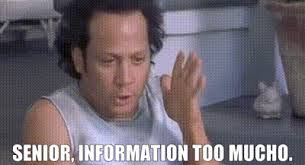

# Exercise 1

Your task is to create a `rest_api_source` configuration for the public **Jaffle Shop API**. This exercise will help you apply what you’ve learned:

### API details:
- **Base URL:** `https://jaffle-shop.scalevector.ai/api/v1`
- **Docs:** [https://jaffle-shop.scalevector.ai/docs](https://jaffle-shop.scalevector.ai/docs)

### Endpoints to load:
- `/orders`

### Requirements:
1. Use `rest_api_source` to define your source config.
2. This API uses **pagination**. Figure out what type is it.
3. Add incremental loading to `orders`, starting from `2017-08-01` and using `ordered_at` as the cursor.
4. Add `processing_steps` to `orders`:
  - Remove records from orders which `order_total` > 500.



### Question:
How many rows does resulted table `orders` contain?


In [266]:
import dlt
from dlt.sources.rest_api import rest_api_source
from google.colab import userdata

orders_config = {
    "client": {
        "base_url": "https://jaffle-shop.scalevector.ai/api/v1",
        "paginator": {
            "type": "header_link",
        },
    },
    "resources": [
        {
            "write_disposition": "replace",
            "name": "orders",
            "processing_steps": [
                    {"filter": lambda x: int(x["order_total"]) > 500},
            ],
            "endpoint": {
                "path": "orders",
                "method": "GET",
                "params": {
                    "page_size": 2000,
                    "from": {
                        "type": "incremental",
                        "cursor_path": "ordered_at",
                        "initial_value": "2017-08-01T00:00:00Z",
                    },
                },
            },
        }
    ]
}

orders_source = rest_api_source(orders_config)

pipeline = dlt.pipeline(
  pipeline_name="orders_pipeline",
  destination="duckdb",
  dataset_name="orders"
)

load_info = pipeline.run(orders_source)
#print(pipeline.last_trace)
print(load_info)
pipeline.dataset(dataset_type="default").orders.df()

Pipeline orders_pipeline load step completed in 1.52 seconds
1 load package(s) were loaded to destination duckdb and into dataset orders
The duckdb destination used duckdb:////content/orders_pipeline.duckdb location to store data
Load package 1746816299.148642 is LOADED and contains no failed jobs


,id,customer_id,store_id,ordered_at,subtotal,tax_paid,order_total,_dlt_load_id,_dlt_id
0,e6273b98-0975-411f-aa71-5f98a82dd908,d9464bcd-0a19-4058-8fc1-bea843e6c339,4b6c2304-2b9e-41e4-942a-cf11a1819378,2017-08-01 12:08:00+00:00,600,36,636,1746816299.148642,kZuTBYkrdcc3CQ
1,880b45ec-3a69-4f6f-b592-ab1d8b7f2f4c,50a2d1c4-d788-4498-a6f7-dd75d4db588f,4b6c2304-2b9e-41e4-942a-cf11a1819378,2017-08-01 15:16:00+00:00,500,30,530,1746816299.148642,HlPzgFeQ0wVdsQ
2,11d1ab57-65c2-4963-a132-d031d71d4b0f,438005c2-dd1d-48aa-8bfd-7fb06851b5f8,4b6c2304-2b9e-41e4-942a-cf11a1819378,2017-08-01 09:49:00+00:00,500,30,530,1746816299.148642,bC86+GGO7VFVbg
3,1dec14e3-ca08-4729-aaeb-d3ba6562e858,847d46dd-9721-4351-8bef-5c2292b57d6f,4b6c2304-2b9e-41e4-942a-cf11a1819378,2017-08-01 08:08:00+00:00,600,36,636,1746816299.148642,pDZESan8Ogj+9g
4,45bdb4e4-37b9-4b3e-b0f4-ec2cf11d851e,5a589b0f-69ac-4256-aea8-df379845f417,4b6c2304-2b9e-41e4-942a-cf11a1819378,2017-08-01 13:03:00+00:00,2400,144,2544,1746816299.148642,AkhOI+bL/Qvmbw
...,...,...,...,...,...,...,...,...,...
7818,d655d186-275f-4411-9a23-2f6d68f97578,2d4e6ed6-f081-4049-b92a-7792dbe97b89,40e6ddd6-b8f6-4e17-8bd6-5e53966809d2,2017-08-31 11:31:00+00:00,600,24,624,1746816299.148642,zMw46sOzlPJBlw
7819,f6d1a004-6d02-4846-974c-aa48891cf1e1,3d6f18db-a49c-4563-9445-68d4e02bd664,40e6ddd6-b8f6-4e17-8bd6-5e53966809d2,2017-08-31 08:14:00+00:00,600,24,624,1746816299.148642,F7mao6ccblIVEQ
7820,505da4ed-218d-47ce-bb62-caadac5da974,e8014144-a99b-4ca2-8418-56404aee2f08,40e6ddd6-b8f6-4e17-8bd6-5e53966809d2,2017-08-31 16:07:00+00:00,600,24,624,1746816299.148642,Pw5tAX3yVSocMQ
7821,1b41551c-b925-4cf5-820f-b014a23015a0,8f054a96-7920-42dc-b286-f6980ea8dbeb,40e6ddd6-b8f6-4e17-8bd6-5e53966809d2,2017-08-31 17:41:00+00:00,1200,48,1248,1746816299.148642,O1/gnqwP1kx2dw


In [267]:
pipeline.dataset(dataset_type="default").orders.df().count()

,0
id,7823
customer_id,7823
store_id,7823
ordered_at,7823
subtotal,7823
tax_paid,7823
order_total,7823
_dlt_load_id,7823
_dlt_id,7823


✅ ▶ Well done! Go to [the next lesson.](https://colab.research.google.com/drive/1lQ8VkrGJwZMsVtbkuYympcvbv0_CCgYo#forceEdit=true&sandboxMode=true)

In [152]:
pipeline